<a href="https://colab.research.google.com/github/r-o-h-a-n-2004/tranfer-learning-using-fine-tuning-/blob/main/transfer%20learing%20with%20funing%20tuning%20RenNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
(train_ds, val_ds), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

# Constants
IMG_SIZE = (224, 224)  # ResNet50 expects 224x224 images
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Data preprocessing and augmentation
def preprocess_image(image, label):
    # Resize and normalize images
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

def augment(image, label):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    # Random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Random brightness and contrast
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Prepare datasets
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Load ResNet50 base model (excluding top layers)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the entire base model initially
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Dropout after first dense layer
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model - Feature Extraction Phase
print("Training the top layers...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping]
)

# Fine-tuning phase: Unfreeze the last convolutional block
# In ResNet50, the last block is 'conv5_block3'
base_model.trainable = True

# Freeze all layers except the last convolutional block
for layer in base_model.layers:
    if 'conv5_block3' not in layer.name:
        layer.trainable = False
    else:
        print(f"Unfreezing layer: {layer.name}")

# Important: Keep BatchNorm layers in inference mode during fine-tuning
for layer in base_model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model - Fine-tuning Phase
print("\nFine-tuning the last convolutional block...")
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"\nFinal Validation Accuracy: {accuracy*100:.2f}%")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.UWD3AB_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Training the top layers...
Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 146s 216ms/step - accuracy: 0.9035 - loss: 0.2400 - val_accuracy: 0.9856 - val_loss: 0.0382
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 116s 192ms/step - accuracy: 0.9536 - loss: 0.1200 - val_accuracy: 0.9796 - val_loss: 0.0490
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 116s 192ms/step - accuracy: 0.9598 - loss: 0.1085 - val_accuracy: 0.9877 - val_loss: 0.0325
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 116s 191ms/step - accuracy: 0.9610 - loss: 0.1004 - val_accuracy: 0.9837 - val_loss: 0.0412
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 145s 196ms/step - accuracy: 0.9621 - loss: 0.0976 - val_accuracy: 0.9884 - val_loss: 0.0323
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 120s 198ms/step - accuracy: 0.9649 - loss: 0.0908 - val_accuracy: 0.9839 - val_loss: 0.03

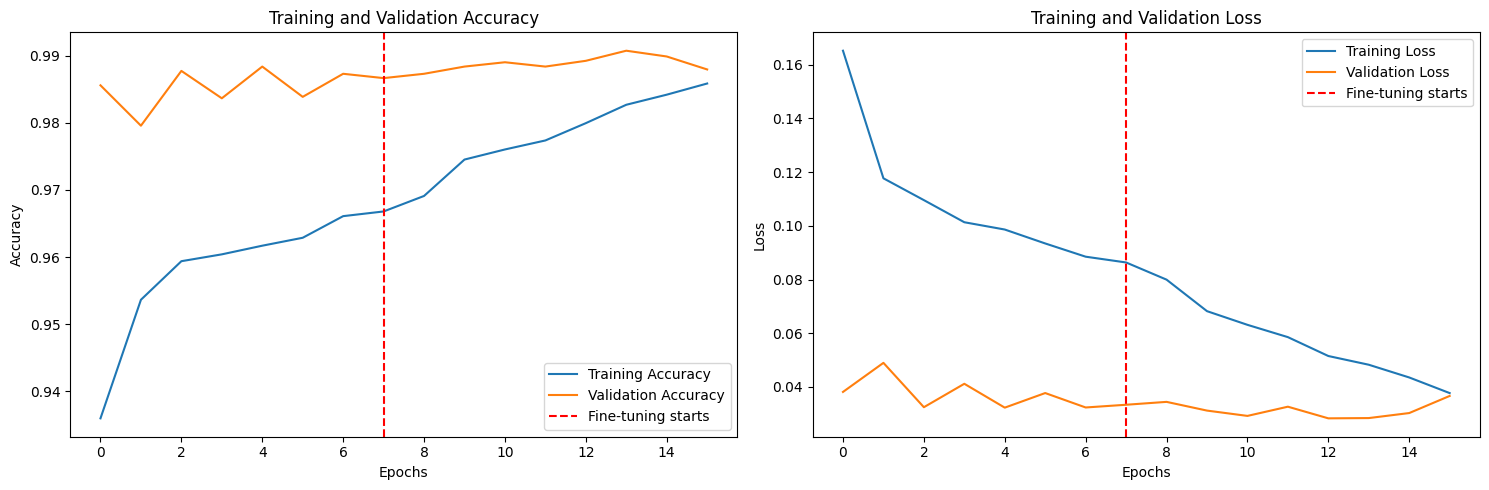

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

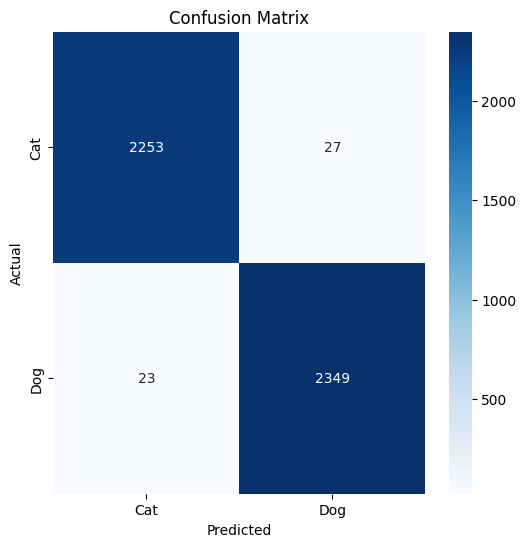

In [3]:
import matplotlib.pyplot as plt

# Combine the histories from both training phases
total_history = {
    'accuracy': history.history['accuracy'] + history_fine.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'] + history_fine.history['val_accuracy'],
    'loss': history.history['loss'] + history_fine.history['loss'],
    'val_loss': history.history['val_loss'] + history_fine.history['val_loss']
}

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(total_history['accuracy'], label='Training Accuracy')
ax1.plot(total_history['val_accuracy'], label='Validation Accuracy')
ax1.axvline(len(history.history['accuracy'])-1, color='r', linestyle='--', label='Fine-tuning starts')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(total_history['loss'], label='Training Loss')
ax2.plot(total_history['val_loss'], label='Validation Loss')
ax2.axvline(len(history.history['loss'])-1, color='r', linestyle='--', label='Fine-tuning starts')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

# Print classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Get predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Cat', 'Dog']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model (optional)
# model.save('cats_vs_dogs_resnet50_finetuned.h5')